In [18]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [2]:
# Load AffectNet dataset from Hugging Face
dataset = load_dataset("chitradrishti/AffectNet")

In [3]:
# Create directories to save preprocessed data
os.makedirs("preprocessed_data", exist_ok=True)

# Create empty lists to store data
X_list = []
y_list = []

In [4]:
# Preprocess AffectNet dataset
def preprocess_affectnet(example):
    # Convert image to grayscale and resize
    image = Image.fromarray(np.array(example["image"], dtype=np.uint8)).convert("L")
    image_resized = image.resize((48, 48))  # Resize to 48x48
    pixels = np.array(image_resized, dtype=np.float32).reshape(48, 48, 1) / 255.0  # Normalize and reshape
    label = example["label"]
    
    # Append to lists
    X_list.append(pixels)
    y_list.append(label)
    
    # Periodically save to disk (e.g., every 1000 samples)
    if len(X_list) % 1000 == 0:
        np.save(f"preprocessed_data/X_partial_{len(X_list)}.npy", np.array(X_list))
        np.save(f"preprocessed_data/y_partial_{len(y_list)}.npy", np.array(y_list))
        print(f"Saved partial data: {len(X_list)} samples")

    return {"pixels": pixels, "emotion": label}

# Apply preprocessing
affectnet_data = dataset["train"].map(preprocess_affectnet)

Map:   0%|          | 0/31002 [00:00<?, ? examples/s]

Saved partial data: 1000 samples
Saved partial data: 2000 samples
Saved partial data: 3000 samples
Saved partial data: 4000 samples
Saved partial data: 5000 samples
Saved partial data: 6000 samples
Saved partial data: 7000 samples
Saved partial data: 8000 samples
Saved partial data: 9000 samples
Saved partial data: 10000 samples
Saved partial data: 11000 samples
Saved partial data: 12000 samples
Saved partial data: 13000 samples
Saved partial data: 14000 samples
Saved partial data: 15000 samples
Saved partial data: 16000 samples
Saved partial data: 17000 samples
Saved partial data: 18000 samples
Saved partial data: 19000 samples
Saved partial data: 20000 samples
Saved partial data: 21000 samples
Saved partial data: 22000 samples
Saved partial data: 23000 samples
Saved partial data: 24000 samples
Saved partial data: 25000 samples
Saved partial data: 26000 samples
Saved partial data: 27000 samples
Saved partial data: 28000 samples
Saved partial data: 29000 samples
Saved partial data: 300

In [5]:
# Save final data after preprocessing completes
X_array = np.array(X_list)
y_array = np.array(y_list)
np.save("preprocessed_data/X_affectnet.npy", X_array)
np.save("preprocessed_data/y_affectnet.npy", y_array)

print("Preprocessed data saved successfully!")

Preprocessed data saved successfully!


In [8]:
# Load the preprocessed data
X = np.load("preproc_affectnet/X_affectnet.npy")
y = np.load("preproc_affectnet/y_affectnet.npy")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# One-hot encode the labels
num_classes = len(np.unique(y))  # Determine the number of unique classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

In [10]:
# Calculate class weights to handle imbalanced datasets
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))

In [14]:
# Define the CNN model
model = Sequential([
    Input(shape=(48, 48, 1)),  # Explicitly define the input shape
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [16]:
# Define callbacks for early stopping, saving the best model, and reducing learning rate
callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
]

In [17]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 230s 295ms/step - accuracy: 0.3246 - loss: 1.8327 - val_accuracy: 0.4998 - val_loss: 1.2809 - learning_rate: 0.0010
Epoch 2/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 219s 282ms/step - accuracy: 0.4742 - loss: 1.4230 - val_accuracy: 0.5283 - val_loss: 1.2160 - learning_rate: 0.0010
Epoch 3/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 286s 368ms/step - accuracy: 0.5285 - loss: 1.2846 - val_accuracy: 0.5431 - val_loss: 1.1775 - learning_rate: 0.0010
Epoch 4/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 249s 321ms/step - accuracy: 0.5657 - loss: 1.1869 - val_accuracy: 0.5430 - val_loss: 1.1812 - learning_rate: 0.0010
Epoch 5/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 333s 428ms/step - accuracy: 0.6106 - loss: 1.0746 - val_accuracy: 0.5506 - val_loss: 1.1655 - learning_rate: 0.0010
Epoch 6/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 351s 452ms/step - accuracy: 0.6469 - loss: 0.9586 - val_accuracy: 0.5636 - val_loss: 1.2214 - learning_rate: 0.0010
Epoch 7/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 213s 274ms/step - accura

In [19]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5629 - loss: 1.4017
Validation Accuracy: 56.89%


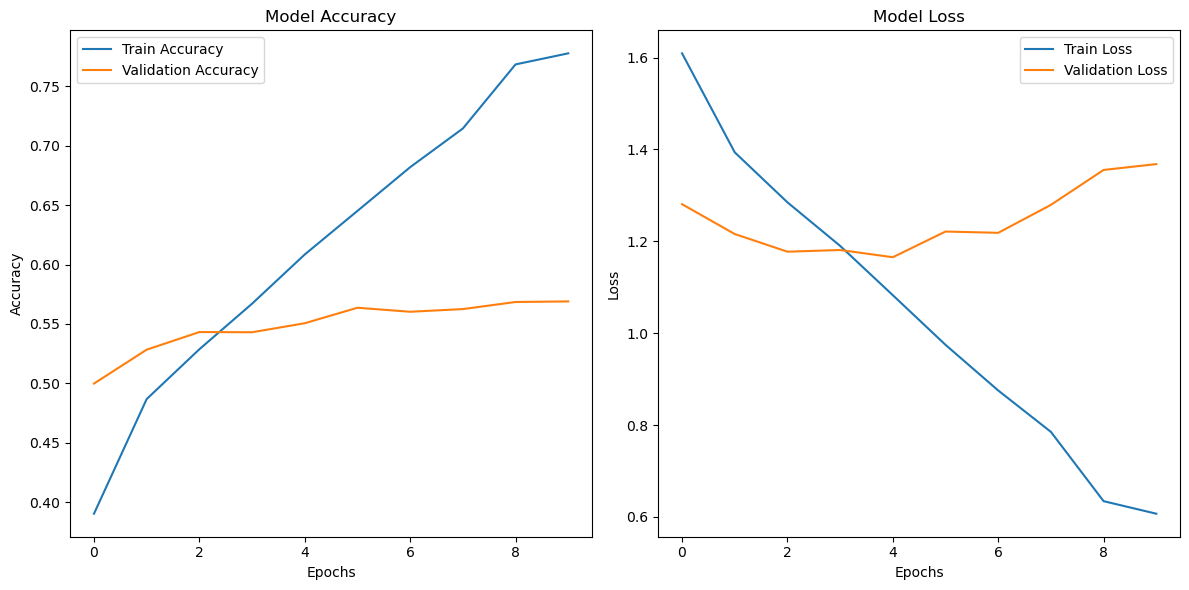

In [21]:
# Plot training history
plt.figure(figsize=(12, 6))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Save the final model
model.save("final_affectnet_model.keras")
print("Final model saved as 'final_affectnet_model.keras'")

Final model saved as 'final_affectnet_model.keras'
